In [165]:
import pdr
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from tqdm import tqdm

import cv2
from scipy.ndimage import gaussian_filter, label
from astropy.stats import sigma_clip

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)

In [ ]:
image_data = pdr.read('test_data/e23456/e23456-nd-ffull-b00-image-r.fits')
movie_data = pdr.read('test_data/e23456/e23456-nd-f0060-b00-movie-r.fits')
#np.shape(movie),np.shape(image)
image = image_data['COUNT']
exptime = image_data['COUNT_HEADER']['XPOSURE']
movie = movie_data['COUNT']
exptimes = [movie_data['COUNT_HEADER'][f'EXPT_{i}'] for i in range(movie_data['COUNT_HEADER']['NAXIS3'])]


In [ ]:
mov = np.array([gaussian_filter(movie[i],sigma=3)/exptimes[i] for i in range(len(exptimes))])

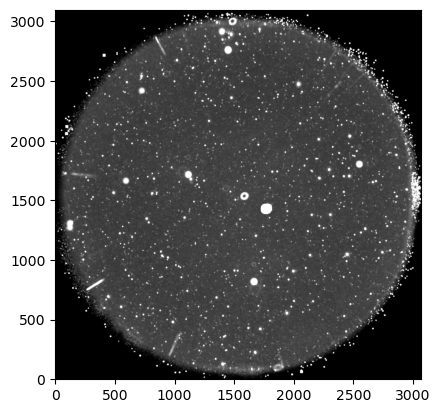

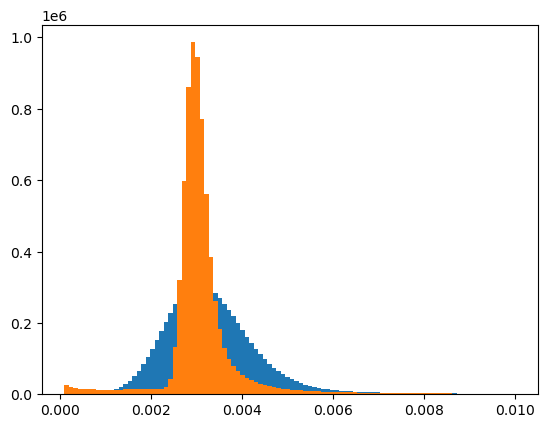

In [229]:
plt.imshow(ZScaleInterval()(gaussian_filter(image, sigma=3)/exptime), cmap='gray', origin='lower');
plt.figure()
plt.hist(gaussian_filter(movie[0], sigma=3).flatten()/exptimes[0],bins=100,range=(0.0001,0.01));
plt.hist(gaussian_filter(image, sigma=3).flatten()/exptime,bins=100,range=(0.0001,0.01));

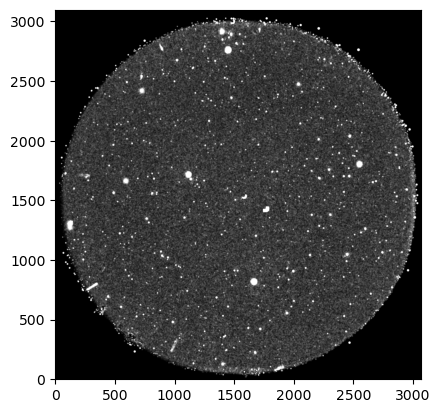

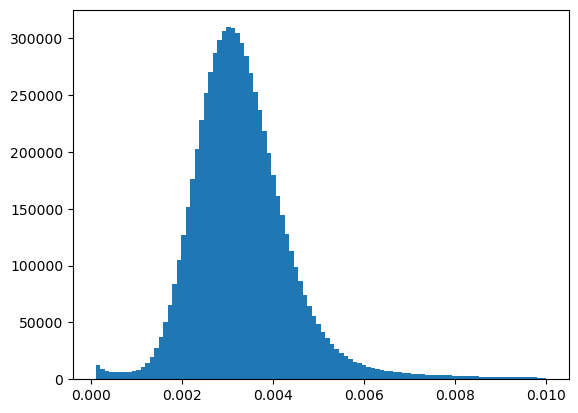

In [ ]:
plt.imshow(ZScaleInterval()(gaussian_filter(movie[0], sigma=3)/exptimes[0]), cmap='gray', origin='lower');
plt.figure()
plt.hist(gaussian_filter(movie[0], sigma=3).flatten()/exptimes[0],bins=100,range=(0.0001,0.01));

0.0011346533


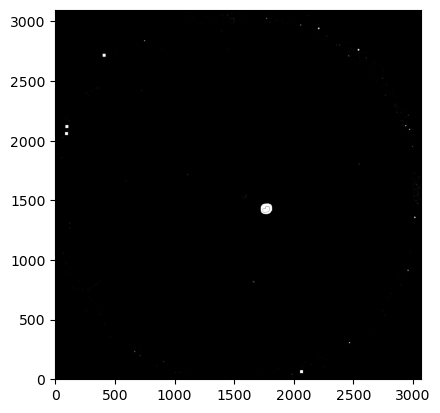

In [176]:
print(thresh:=np.percentile(diff[np.where(diff>0)],80))
plt.imshow(ZScaleInterval()(diff*(diff>thresh)), cmap='gray', origin='lower');

  0%|          | 0/29 [00:01<?, ?it/s]


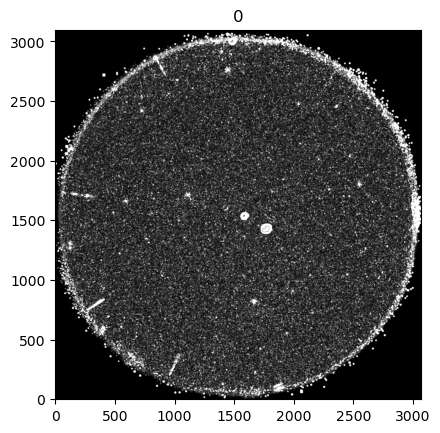

In [182]:
for i in tqdm(range(len(movie))):
    a = gaussian_filter(image, sigma=3)/exptime
    b = gaussian_filter(movie[i], sigma=3)/exptimes[i]
    diff = np.abs(a-b)
    plt.figure()
    plt.title(i)
    plt.imshow(ZScaleInterval()(cv2.medianBlur(diff,5)), cmap='gray', origin='lower');

    # plt.figure()
    # ix = np.where(diff!=0)
    # plt.hist(diff[ix].flatten(),bins=100,range=(0,0.01));
    break


Threshold at 2.517220973968506


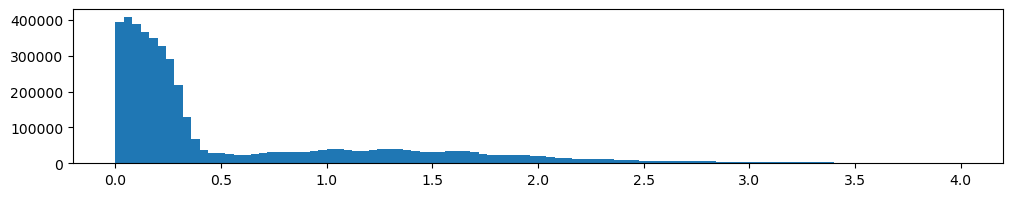

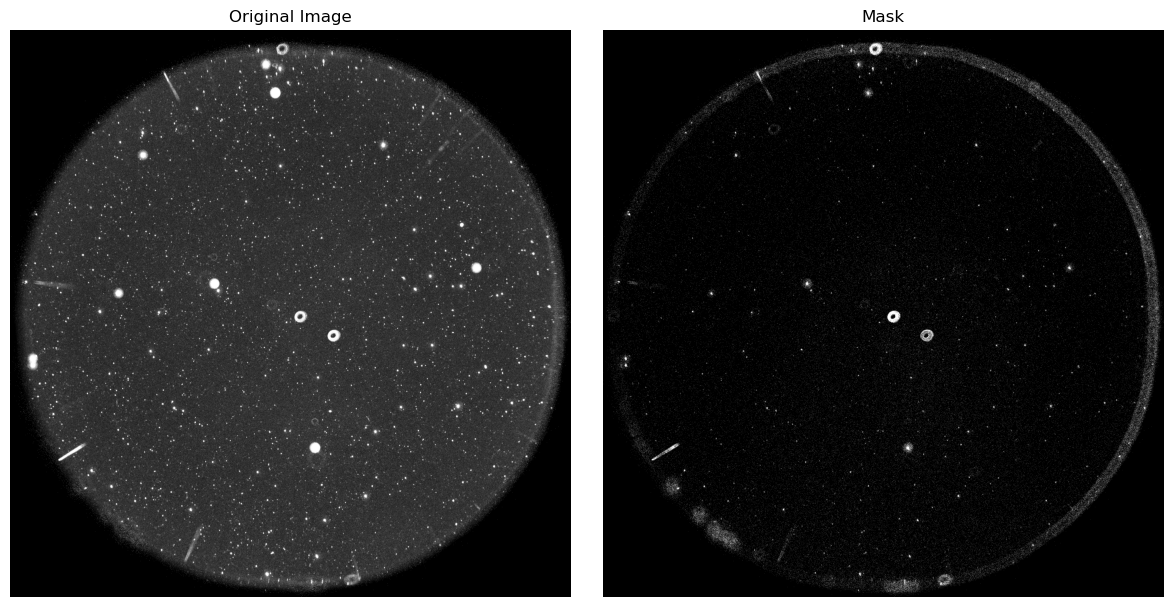

In [228]:
temporal_mean = np.mean(movie, axis=0)
temporal_var = np.var(movie, axis=0)
expected_var = temporal_mean
n_frames = stack.shape[0]

epsilon: float = 1e-10
var_std = np.sqrt(2 * expected_var / n_frames + epsilon)

# Significance map: how many sigma away from expected
significance = (temporal_var - expected_var) / (var_std + epsilon)

percentile_significance = 95

ix = np.where(significance>0)
significance_threshold = np.percentile(significance[ix], percentile_significance)
print(f'Threshold at {significance_threshold}')
# Create binary mask of significant changes
mask = significance > significance_threshold

# ---

plt.figure(figsize=(12,2))
ix = np.where(significance>0)
plt.hist(significance[ix].flatten(), bins=100,range=(0,4));
np.percentile(significance[ix], percentile_significance)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axes[0].imshow(ZScaleInterval()(image), cmap='gray', origin='lower')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot the mask
# axes[1].imshow(ZScaleInterval()(cv2.bilateralFilter((mask * significance).astype(np.uint8), 5, 50, 50)), cmap='gray', origin='lower')
axes[1].imshow(ZScaleInterval()((mask * significance).astype(np.uint8)), cmap='gray', origin='lower')
axes[1].set_title('Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Threshold at 1.6288706064224243


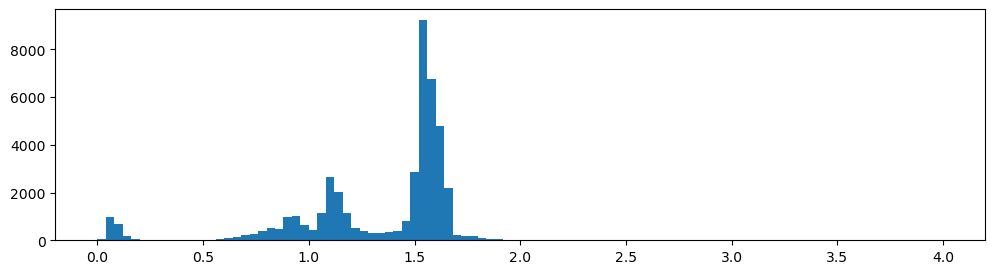

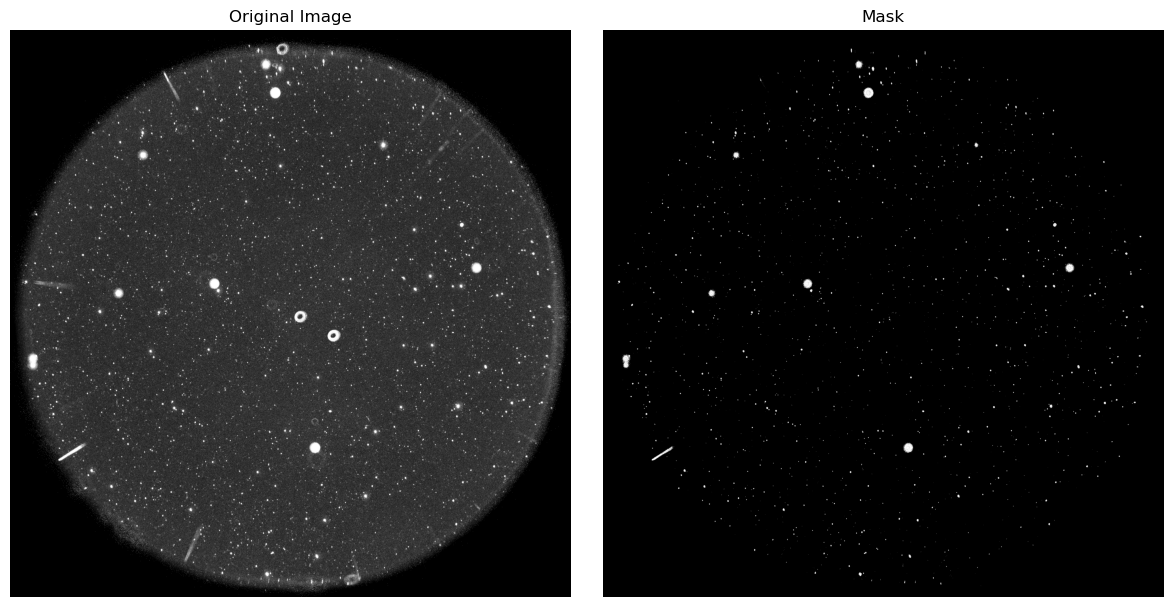

In [224]:
# MAD

# Compute temporal median (more robust than mean)
temporal_median = np.median(movie, axis=0)

# Compute MAD
deviations = np.abs(movie - temporal_median[np.newaxis, :, :])
mad = np.median(deviations, axis=0)

# For Poisson noise, expected MAD ≈ 0.67 * sqrt(median)
epsilon = 1e-10
expected_mad = 0.67 * np.sqrt(temporal_median + epsilon)

# Significance based on MAD
significance = mad / (expected_mad + epsilon)

# Create mask
significance_threshold = np.percentile(significance[ix], 90)
print(f'Threshold at {significance_threshold}')
mask = significance > significance_threshold

# ---

plt.figure(figsize=(12,3))
ix = np.where(significance>0)
plt.hist(significance[ix].flatten(), bins=100,range=(0,4));
np.percentile(significance[ix], 95)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axes[0].imshow(ZScaleInterval()(image), cmap='gray', origin='lower')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot the mask
# axes[1].imshow(np.array(mask,dtype=bool), cmap='gray', origin='lower')
axes[1].imshow(ZScaleInterval()(significance), cmap='gray', origin='lower')
axes[1].set_title('Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()